In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns ; sns.set()
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# measuring RMSE score
from sklearn.metrics import mean_squared_error

from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

xgb = XGBClassifier()
kkn = KNeighborsClassifier(n_neighbors=4)
mlp = MLPClassifier()
lr = LogisticRegression()
svc = SVC(kernel='rbf',C=5)



from datetime import datetime


In [2]:
raw_data = pd.read_csv('Datasets/smart_grid_stability_augmented01.csv')

map1 = {'unstable': 0, 'stable': 1}
raw_data['stabf'] = raw_data['stabf'].replace(map1)

In [3]:
# raw_data = pd.read_csv('Datasets/smart_grid_stability_augmented.csv')

# raw_data.loc[raw_data['stabf']=='unstable', 'stabf'] = 0
# raw_data.loc[raw_data['stabf']=='stable', 'stabf'] = 1

In [4]:
raw_data.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,0
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,1
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,0
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,0
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,0


In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tau1    60000 non-null  float64
 1   tau2    60000 non-null  float64
 2   tau3    60000 non-null  float64
 3   tau4    60000 non-null  float64
 4   p1      60000 non-null  float64
 5   p2      60000 non-null  float64
 6   p3      60000 non-null  float64
 7   p4      60000 non-null  float64
 8   g1      60000 non-null  float64
 9   g2      60000 non-null  float64
 10  g3      60000 non-null  float64
 11  g4      60000 non-null  float64
 12  stab    60000 non-null  float64
 13  stabf   60000 non-null  int64  
dtypes: float64(13), int64(1)
memory usage: 6.4 MB


In [6]:
def assessment(f_data, f_y_feature, f_x_feature, f_index=-1):
    """
    Develops and displays a histogram and a scatter plot for a dependent / independent variable pair from
    a dataframe and, optionally, highlights a specific observation on the plot in a different color (red).
    
    Also optionally, if an independent feature is not informed, the scatterplot is not displayed.
    
    Keyword arguments:
    
    f_data      Tensor containing the dependent / independent variable pair.
                Pandas dataframe
    f_y_feature Dependent variable designation.
                String
    f_x_feature Independent variable designation.
                String
    f_index     If greater or equal to zero, the observation denoted by f_index will be plotted in red.
                Integer
    """
    for f_row in f_data:
        if f_index >= 0:
            f_color = np.where(f_data[f_row].index == f_index,'r','g')
            f_hue = None
        else:
            f_color = 'b'
            f_hue = None
    
    f_fig, f_a = plt.subplots(1, 2, figsize=(16,4))
    
    f_chart1 = sns.histplot(f_data[f_x_feature], ax=f_a[0], kde=False, color='g')
    f_chart1.set_xlabel(f_x_feature,fontsize=10)

    
    if f_index >= 0:
        f_chart2 = plt.scatter(f_data[f_x_feature], f_data[f_y_feature], c=f_color, edgecolors='w')
        f_chart2 = plt.xlabel(f_x_feature, fontsize=10)
        f_chart2 = plt.ylabel(f_y_feature, fontsize=10)
    else:
        f_chart2 = sns.scatterplot(x=f_x_feature, y=f_y_feature, data=f_data, hue=f_hue, legend=False)
        f_chart2.set_xlabel(f_x_feature,fontsize=10)
        f_chart2.set_ylabel(f_y_feature,fontsize=10)

    plt.show()

    
def correlation_map(f_data, f_feature, f_number):
    """
    Develops and displays a heatmap plot referenced to a primary feature of a dataframe, highlighting
    the correlation among the 'n' mostly correlated features of the dataframe.
    
    Keyword arguments:
    
    f_data      Tensor containing all relevant features, including the primary.
                Pandas dataframe
    f_feature   The primary feature.
                String
    f_number    The number of features most correlated to the primary feature.
                Integer
    """
    f_most_correlated = f_data.corr().nlargest(f_number,f_feature)[f_feature].index
    f_correlation = f_data[f_most_correlated].corr()
    
    f_mask = np.zeros_like(f_correlation)
    f_mask[np.triu_indices_from(f_mask)] = True
    with sns.axes_style("white"):
        f_fig, f_ax = plt.subplots(figsize=(20, 10))
        sns.heatmap(f_correlation, mask=f_mask, vmin=-1, vmax=1, square=True,
                    center=0, annot=True, annot_kws={"size": 8}, cmap="PRGn")
    plt.show()

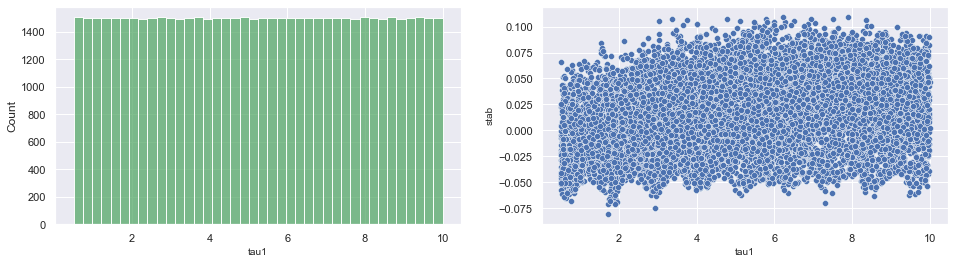

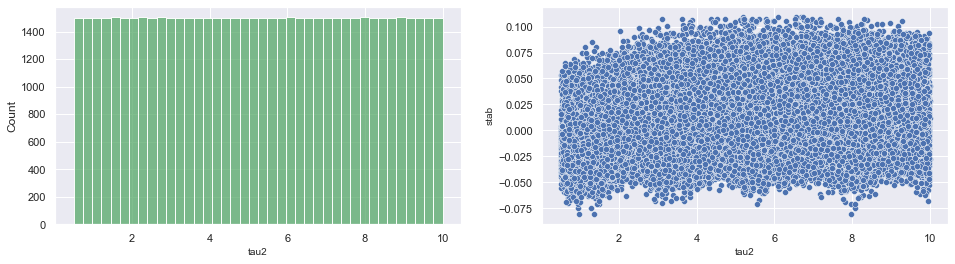

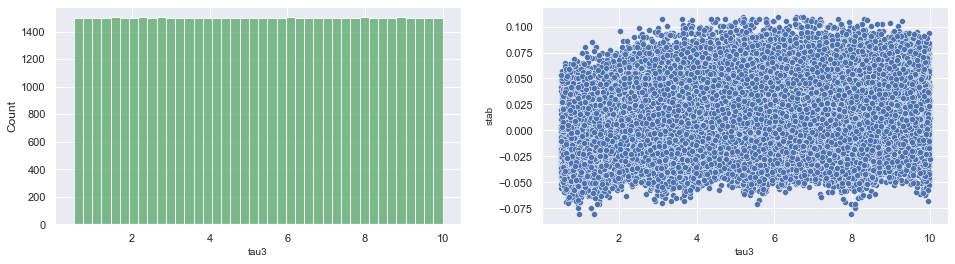

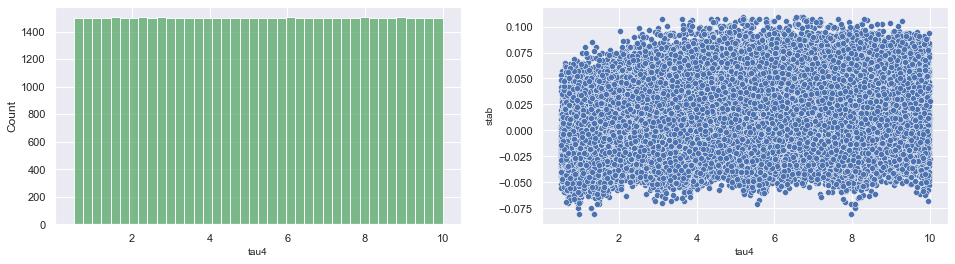

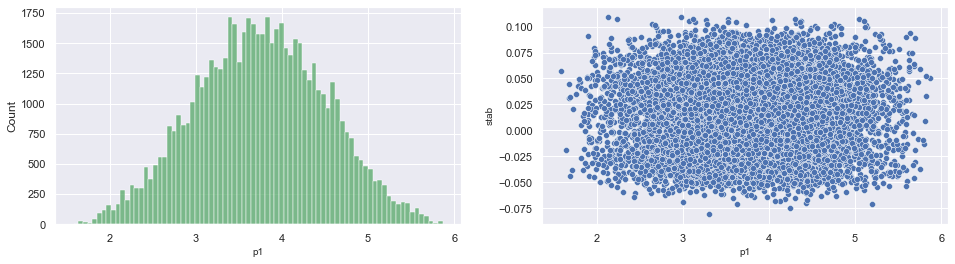

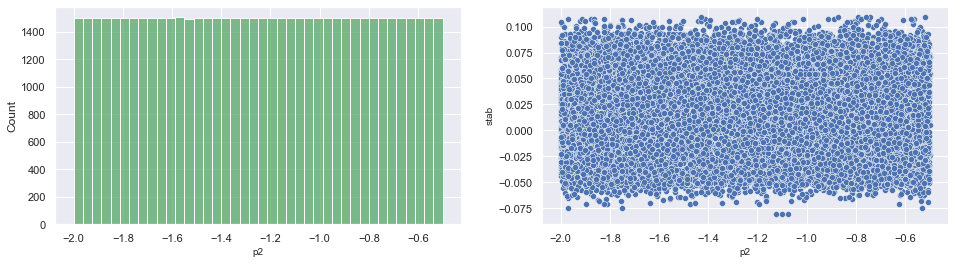

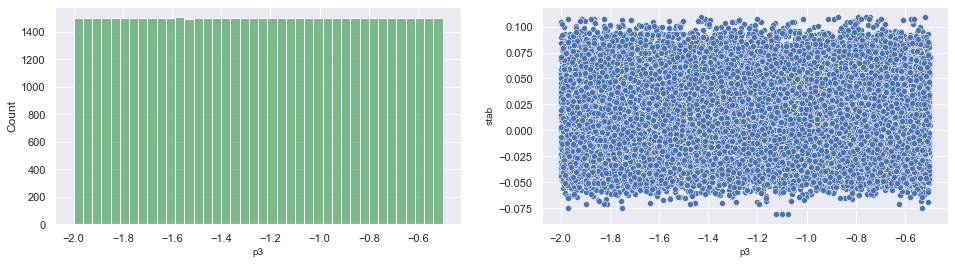

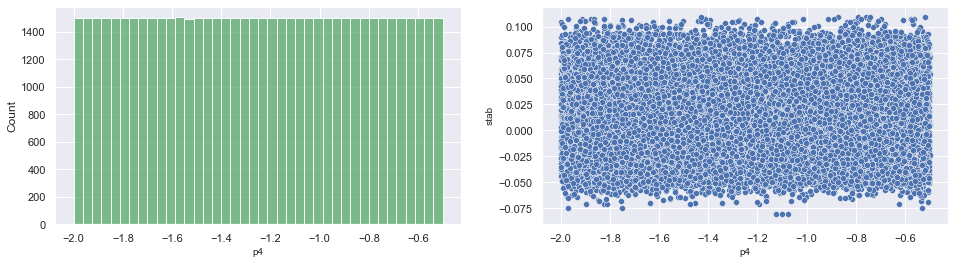

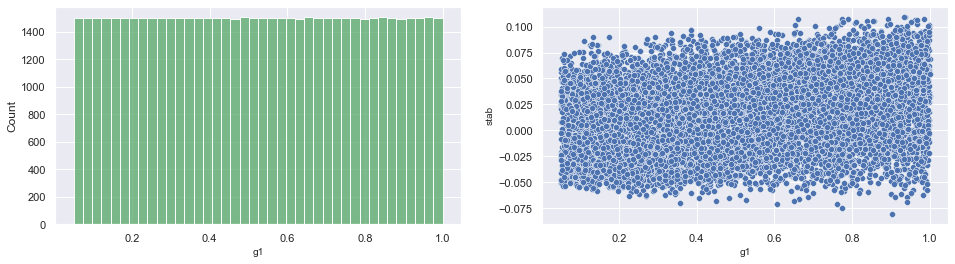

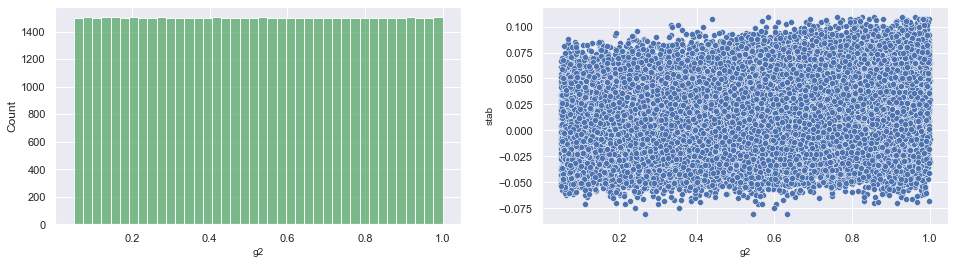

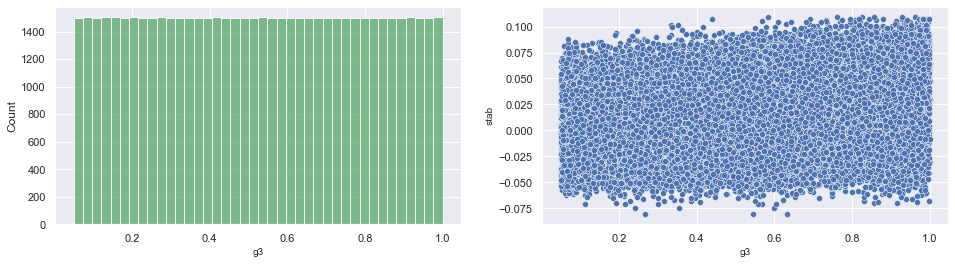

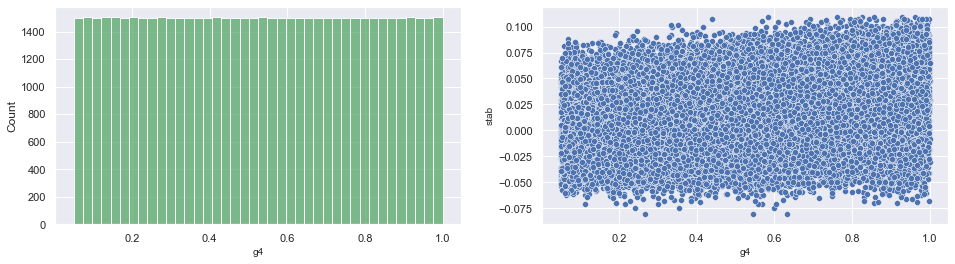

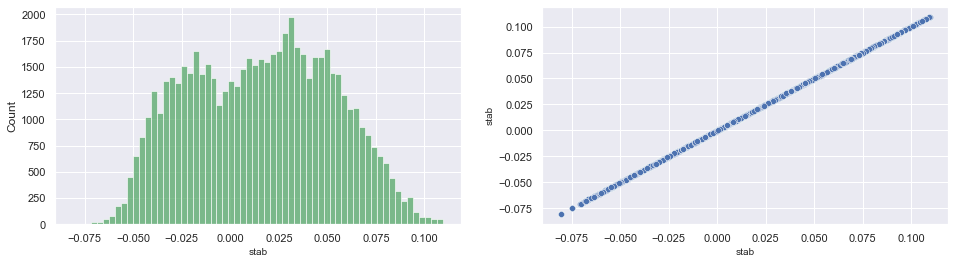

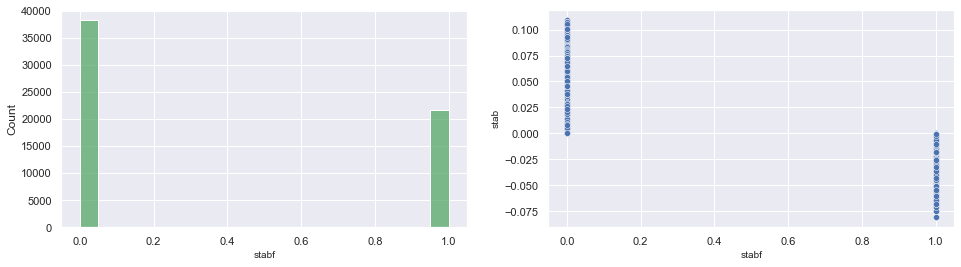

In [7]:
for column in raw_data.columns:
    assessment(raw_data, 'stab', column, -1)

In [8]:
print(f'Split of "unstable" (0) and "stable" (1) observations in the original dataset:')
print(raw_data['stabf'].value_counts(normalize=True))

Split of "unstable" (0) and "stable" (1) observations in the original dataset:
0    0.638
1    0.362
Name: stabf, dtype: float64


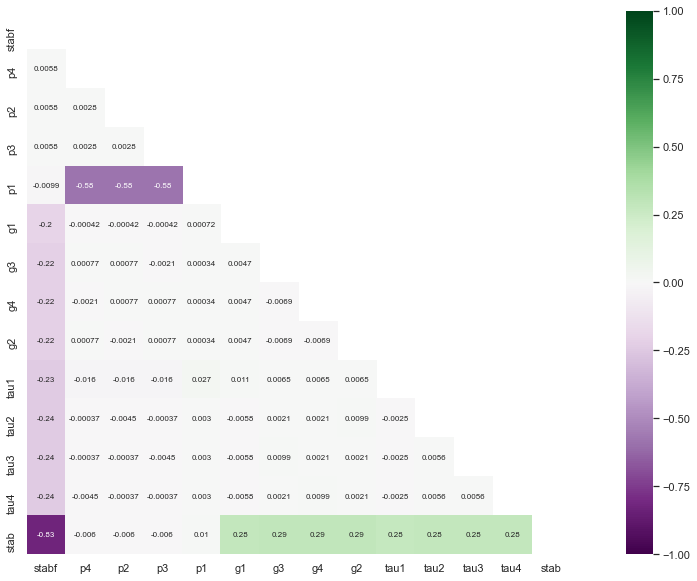

In [9]:
correlation_map(raw_data, 'stabf', 14)

In [10]:
raw_data.describe()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,5.250000,5.250001,5.250001,5.250001,3.750000,-1.250000,-1.250000,-1.250000,0.525000,0.525000,0.525000,0.525000,0.015731,0.362000
std,2.742434,2.742437,2.742437,2.742437,0.752129,0.433017,0.433017,0.433017,0.274244,0.274243,0.274243,0.274243,0.036917,0.480583
min,0.500793,0.500141,0.500141,0.500141,1.582590,-1.999945,-1.999945,-1.999945,0.050009,0.050028,0.050028,0.050028,-0.080760,0.000000
25%,2.874892,2.875011,2.875011,2.875011,3.218300,-1.624997,-1.624997,-1.624997,0.287521,0.287497,0.287497,0.287497,-0.015557,0.000000
50%,5.250004,5.249981,5.249981,5.249981,3.751025,-1.249996,-1.249996,-1.249996,0.525009,0.525007,0.525007,0.525007,0.017142,0.000000
75%,7.624690,7.624896,7.624896,7.624896,4.282420,-0.874993,-0.874993,-0.874993,0.762435,0.762490,0.762490,0.762490,0.044878,1.000000
max,9.999469,9.999837,9.999837,9.999837,5.864418,-0.500025,-0.500025,-0.500025,0.999937,0.999982,0.999982,0.999982,0.109403,1.000000


In [11]:
raw_data = raw_data.apply(pd.to_numeric)
data = raw_data.values

X = data[:, :13]
y = data[:, 13]
print(raw_data.shape)
print(X.shape)
print(y.shape)

(60000, 14)
(60000, 13)
(60000,)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2, stratify=y, shuffle=True)

In [13]:
# data normalization with sklearn
norm = MinMaxScaler().fit(X_train)
X_train_norm = norm.transform(X_train)
X_test_norm = norm.transform(X_test)

In [14]:
# data standardization with  sklearn

scale = StandardScaler().fit(X_train)
X_train_stand = scale.transform(X_train)
X_test_stand = scale.transform(X_test)

In [15]:
# raw, normalized and standardized training and testing data
trainX = [X_train, X_train_norm, X_train_stand]
testX = [X_test, X_test_norm, X_test_stand]

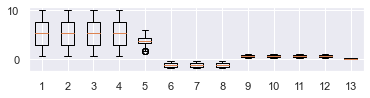

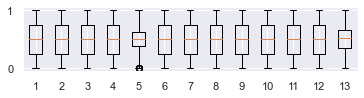

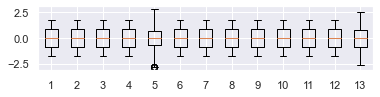

In [16]:
for i, data in enumerate(trainX):
    fig = plt.figure()
    ax = fig.add_subplot(3,1,i+1)
    ax.boxplot(data);

In [17]:
# # xgb
# rmse = []
# y_p = []

# # raw, normalized and standardized training and testing data
# trainX = [X_train, X_train_norm, X_train_stand]
# testX = [X_test, X_test_norm, X_test_stand]

# xgb = XGBClassifier()

# normalaiz_model = ["original_data", 'normalaiz_data', 'standard_data']
# # model fitting and measuring RMSE

# for i in range(len(trainX)):

#     # fit
#     xgb.fit(trainX[i],y_train)
#     # predict
#     pred = xgb.predict(testX[i])
#     y_p.append(np.array(pred))
#     # RMSE
#     rmse.append(np.sqrt(mean_squared_error(y_test,pred)))
#     #accurecy
#     print('Accuracy for',  normalaiz_model[i] , '%.2f'%accuracy_score(y_test, pred))


# # visualizing the result
# df_xgb = pd.DataFrame({'RMSE':rmse},index=['Original','Normalized','Standardized'])
# df_xgb 

In [18]:
# knn
rmse = []
y_p = []

# raw, normalized and standardized training and testing data
trainX = [X_train, X_train_norm, X_train_stand]
testX = [X_test, X_test_norm, X_test_stand]

knn = KNeighborsClassifier(n_neighbors=4)

normalaiz_model = ["original_data", 'normalaiz_data', 'standard_data']
# model fitting and measuring RMSE

for i in range(len(trainX)):

    # fit
    knn.fit(trainX[i],y_train)
    # predict
    pred = knn.predict(testX[i])
    y_p.append(np.array(pred))
    # RMSE
    rmse.append(np.sqrt(mean_squared_error(y_test,pred)))
    #accurecy
    print('Accuracy for',  normalaiz_model[i] , '%.2f'%accuracy_score(y_test, pred))


# visualizing the result
df_knn = pd.DataFrame({'RMSE':rmse},index=['Original','Normalized','Standardized'])
df_knn 

Accuracy for original_data 0.82
Accuracy for normalaiz_data 0.92
Accuracy for standard_data 0.94


,RMSE
Original,0.429185
Normalized,0.286007
Standardized,0.246577


In [19]:
# mlp
rmse = []
y_p = []

# raw, normalized and standardized training and testing data
trainX = [X_train, X_train_norm, X_train_stand]
testX = [X_test, X_test_norm, X_test_stand]

mlp = MLPClassifier()

normalaiz_model = ["original_data", 'normalaiz_data', 'standard_data']
# model fitting and measuring RMSE

for i in range(len(trainX)):

    # fit
    mlp.fit(trainX[i],y_train)
    # predict
    pred = mlp.predict(testX[i])
    y_p.append(np.array(pred))
    # RMSE
    rmse.append(np.sqrt(mean_squared_error(y_test,pred)))
    #accurecy
    print('Accuracy for',  normalaiz_model[i] , '%.2f'%accuracy_score(y_test, pred))


# visualizing the result
df_mlp = pd.DataFrame({'RMSE':rmse},index=['Original','Normalized','Standardized'])
df_mlp 

Accuracy for original_data 1.00
Accuracy for normalaiz_data 1.00
Accuracy for standard_data 1.00


,RMSE
Original,0.050332
Normalized,0.048305
Standardized,0.025820


In [20]:
# lr
rmse = []
y_p = []

# raw, normalized and standardized training and testing data
trainX = [X_train, X_train_norm, X_train_stand]
testX = [X_test, X_test_norm, X_test_stand]

lr = LogisticRegression()

normalaiz_model = ["original_data", 'normalaiz_data', 'standard_data']
# model fitting and measuring RMSE

for i in range(len(trainX)):

    # fit
    lr.fit(trainX[i],y_train)
    # predict
    pred = lr.predict(testX[i])
    y_p.append(np.array(pred))
    # RMSE
    rmse.append(np.sqrt(mean_squared_error(y_test,pred)))
    #accurecy
    print('Accuracy for',  normalaiz_model[i] , '%.2f'%accuracy_score(y_test, pred))


# visualizing the result
df_lr = pd.DataFrame({'RMSE':rmse},index=['Original','Normalized','Standardized'])
df_lr 

Accuracy for original_data 0.96
Accuracy for normalaiz_data 1.00
Accuracy for standard_data 1.00


C:\Users\Kian\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,RMSE
Original,0.196469
Normalized,0.064807
Standardized,0.029439


In [21]:
# svc
rmse = []
y_p = []

# raw, normalized and standardized training and testing data
trainX = [X_train, X_train_norm, X_train_stand]
testX = [X_test, X_test_norm, X_test_stand]

svc = SVC(kernel='rbf',C=5)

normalaiz_model = ["original_data", 'normalaiz_data', 'standard_data']
# model fitting and measuring RMSE

for i in range(len(trainX)):

    # fit
    svc.fit(trainX[i],y_train)
    # predict
    pred = svc.predict(testX[i])
    y_p.append(np.array(pred))
    # RMSE
    rmse.append(np.sqrt(mean_squared_error(y_test,pred)))
    #accurecy
    print('Accuracy for',  normalaiz_model[i] , '%.2f'%accuracy_score(y_test, pred))


# visualizing the result
df_svc = pd.DataFrame({'RMSE':rmse},index=['Original','Normalized','Standardized'])
df_svc 

Accuracy for original_data 0.96
Accuracy for normalaiz_data 0.99
Accuracy for standard_data 1.00


,RMSE
Original,0.205751
Normalized,0.081650
Standardized,0.070238
